# Stress Testing

## Variables

In [ ]:
SEED_RANDOM = 101

EPOCHS_WGAN = 1000
EPOCHS_CVAE = 500
LATENT_DIM = 2
NOISE_DIM = 10
WGANGP_PATIENCE = 400

NUM_SCENARIOS = 10000

LOAD_MODEL = False
LOGGING_ENABLED = False
USE_GPU = True

FOLDER_LOAD_MODELS = "models"

START_DATE = "2004-01-01"
START_BACKTEST = "2020-02-20"
END_BACKTEST = "2020-05-01"
END_DATE = "2021-01-01"

## Imports

In [2]:
import random
import logging
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

2025-03-11 15:03:49.377149: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-11 15:03:49.407651: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-11 15:03:50.044730: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from custom_libraries.start_gpu import gpu_available
from custom_libraries.download_data import (
    download_market_data,
    download_fred_data,
    download_other_data,
)
from custom_libraries.preprocess_data import (
    preprocess_market_data,
    preprocess_macro_data,
    process_input_features,
)
from custom_libraries.utils_plot import (
    plot_missing_values,
    plot_correlation_matrix,
    plot_stock_returns,
    plot_macro_trend,
    plot_gan_losses,
    plot_historical_vs_synthetic_var_period,
    plot_mean_grad_features,
    plot_historical_vs_synthetic_var_period_per_tickers,
)
from custom_libraries.utils import (
    save_models,
    load_models,
)
from custom_libraries.stress_backtesting import (
    rolling_backtest,
    detailed_evaluation_forecast,
    backtest_tickers_ret_syn,
)
from custom_libraries.utils_plot import (
    plot_bar_diff,
    plot_scatter_actual_vs_synthetic_oblique,
    plot_latent_space_clustering,
    plot_distribution_synthetic_portfolio,
)

In [ ]:
if LOGGING_ENABLED:
    logging.basicConfig(filename="debug.log", level=logging.INFO)
else:
    logging.basicConfig(level=logging.DEBUG)

In [5]:
gpu_available(USE_GPU)

Number of GPUs Available: 1
Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory limited to 8GB (8192MB)


## Data

### Parameters

In [6]:
np.random.seed(SEED_RANDOM)
random.seed(SEED_RANDOM)
tf.random.set_seed(SEED_RANDOM)

start_date = START_DATE
backtest_start = START_BACKTEST
backtest_end = END_BACKTEST
end_date = END_DATE

# To allow forward fill, download macro data starting 1 year earlier
pre_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime(
    "%Y-%m-%d"
)

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [7]:
portfolio_df = pd.read_csv("portfolio.csv")
tickers = portfolio_df["ticker"].tolist()

portfolio_df["weight"] = portfolio_df["weight"] / 100.0
portfolio_weights = portfolio_df["weight"].values

### Download Market Data

In [8]:
market_data = download_market_data(tickers, pre_start_date, end_date)
market_data.head()

YF.download() has changed argument auto_adjust default to True


Price          Close                                                      \
Ticker          AAPL    AMZN        AXP        BAC       BIIB         BK   
Date                                                                       
2003-01-02  0.222693  0.9785  23.394026  20.762497  34.340000  15.763547   
2003-01-03  0.224197  1.0260  23.476963  20.633247  33.689999  15.869808   
2003-01-06  0.224197  1.0350  24.299929  20.929939  34.230000  16.663612   
2003-01-07  0.223445  1.0775  23.974571  20.962248  34.240002  16.588598   
2003-01-08  0.218931  1.0510  23.795942  20.877064  33.029999  15.938553   

Price                                                  ...   Volume          \
Ticker           COST       DVA         GL         GS  ...      PNC    SIRI   
Date                                                   ...                    
2003-01-02  19.460594  8.363333  13.479935  50.043808  ...   792500  225260   
2003-01-03  18.950769  8.460000  13.487144  50.568306  ...  1109100  117150   
2003-01-06  19.178841  8.483333  13.703865  52.450806  ...  1756200  162380   
2003-01-07  19.487419  8.416667  13.544940  52.235237  ...  1597900  641390   
2003-01-08  19.655125  8.376667  13.508814  50.956303  ...  1335400  553830   

Price                                                                       \
Ticker           SPY      SU     TEVA      TRV      UPS      USB      VRSN   
Date                                                                         
2003-01-02  44516300  864800  6000400   833000  2805000  5131000   6949000   
2003-01-03  32222600  757200  4711600   961100  1935500  3398700   3147300   
2003-01-06  40984500  718000  7149600  1200300  3052500  6704900   5064200   
2003-01-07  38640400  631600  6454800  1441100  2370400  5067900  10772800   
2003-01-08  38702200  751200  3277400  1385300  1680900  3579900  10515000   

Price                
Ticker          WFC  
Date                 
2003-01-02  9904200  
2003-01-03  7808000  
2003-01-06  8097400  
2003-01-07  6556200  
2003-01-08  8071000  

[5 rows x 150 columns]

In [9]:
returns_all, returns_train, returns_test, returns_train_scaled, returns_scaler = (
    preprocess_market_data(market_data, start_date, backtest_start, backtest_end)
)
returns_train.head()

Ticker          AAPL      AMZN       AXP       BAC      BIIB        BK  \
Date                                                                     
2004-01-02 -0.004220 -0.013777 -0.010002 -0.016801  0.006518 -0.009404   
2004-01-05  0.040973  0.026055  0.008758  0.002904  0.004322  0.040907   
2004-01-06 -0.003616 -0.004516  0.001659 -0.001640  0.039376  0.015387   
2004-01-07  0.022383 -0.021539  0.002897 -0.002275  0.055444 -0.035184   
2004-01-08  0.033518 -0.032507 -0.002897  0.000506  0.011214 -0.001194   

Ticker          COST       DVA        GL        GS  ...       PNC      SIRI  \
Date                                                ...                       
2004-01-02 -0.023402  0.012992  0.000439 -0.016338  ... -0.004395  0.189678   
2004-01-05 -0.004691  0.011075  0.007016  0.000515  ... -0.013487 -0.087487   
2004-01-06  0.011277 -0.012341 -0.002625 -0.005986  ...  0.008335 -0.040822   
2004-01-07  0.014123 -0.004063 -0.001096  0.020797  ... -0.002955 -0.058209   
2004-01-08  0.004842 -0.006894  0.000000  0.001215  ... -0.003151  0.058209   

Ticker           SPY        SU      TEVA       TRV       UPS       USB  \
Date                                                                     
2004-01-02 -0.000450  0.016228  0.020248 -0.001262 -0.012146 -0.007314   
2004-01-05  0.010820  0.008990  0.027105  0.002522  0.003795 -0.009999   
2004-01-06  0.000978  0.018886 -0.016277 -0.007586 -0.006105 -0.015011   
2004-01-07  0.003371 -0.017720 -0.003940  0.000000 -0.003272 -0.000703   
2004-01-08  0.003977 -0.027582 -0.002233  0.006325 -0.008226 -0.006711   

Ticker          VRSN       WFC  
Date                            
2004-01-02  0.002451 -0.012302  
2004-01-05  0.045462  0.004802  
2004-01-06  0.045722 -0.003255  
2004-01-07 -0.017470 -0.010179  
2004-01-08  0.043932 -0.000347  

[5 rows x 30 columns]

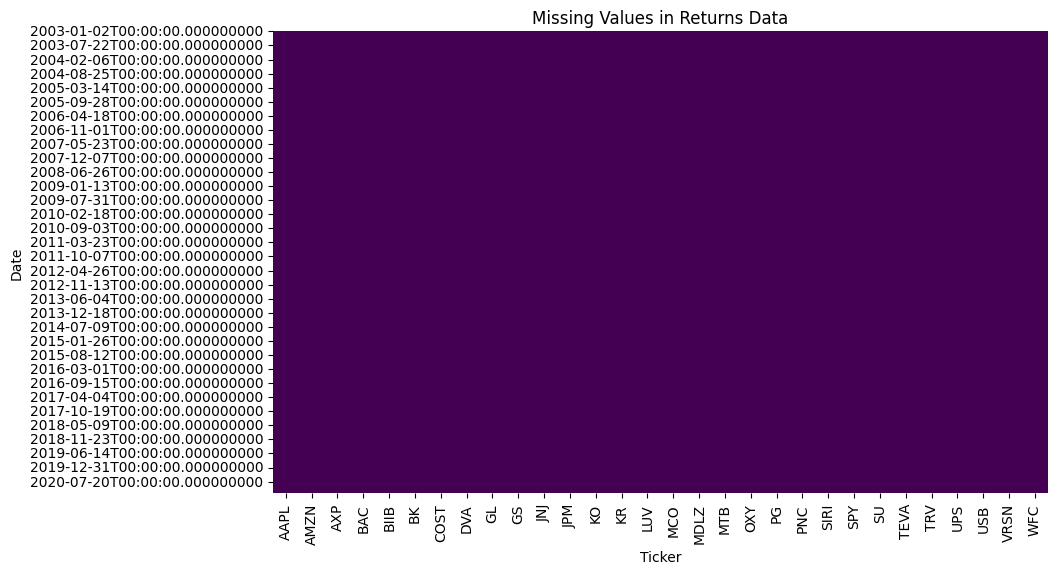

In [10]:
plot_missing_values(returns_all, "Missing Values in Returns Data")

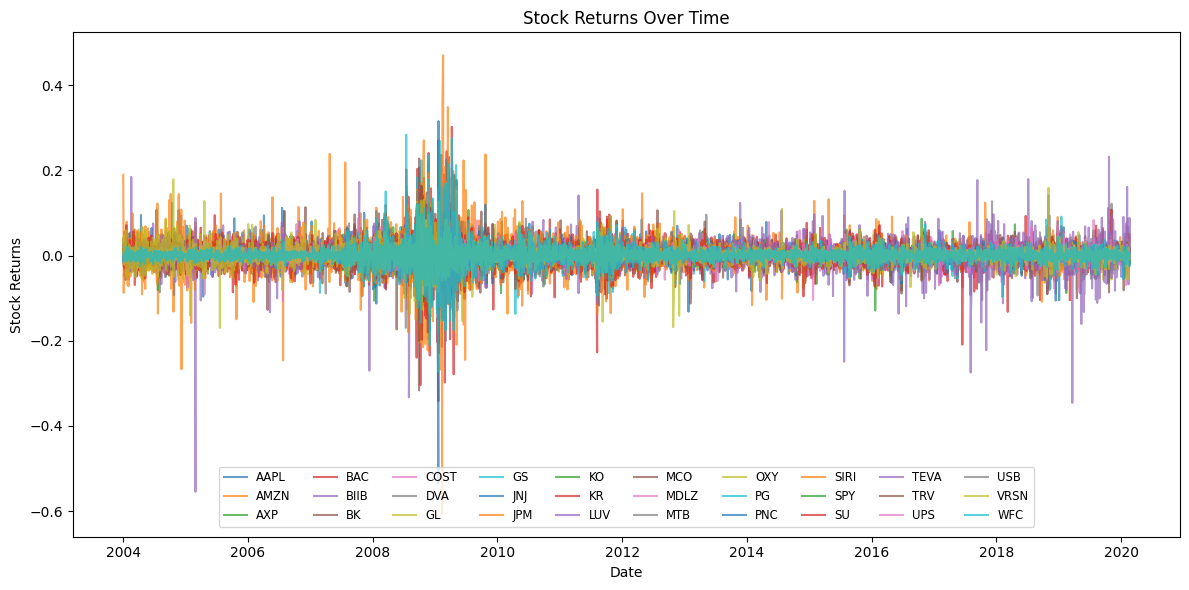

In [11]:
plot_stock_returns(returns_train)

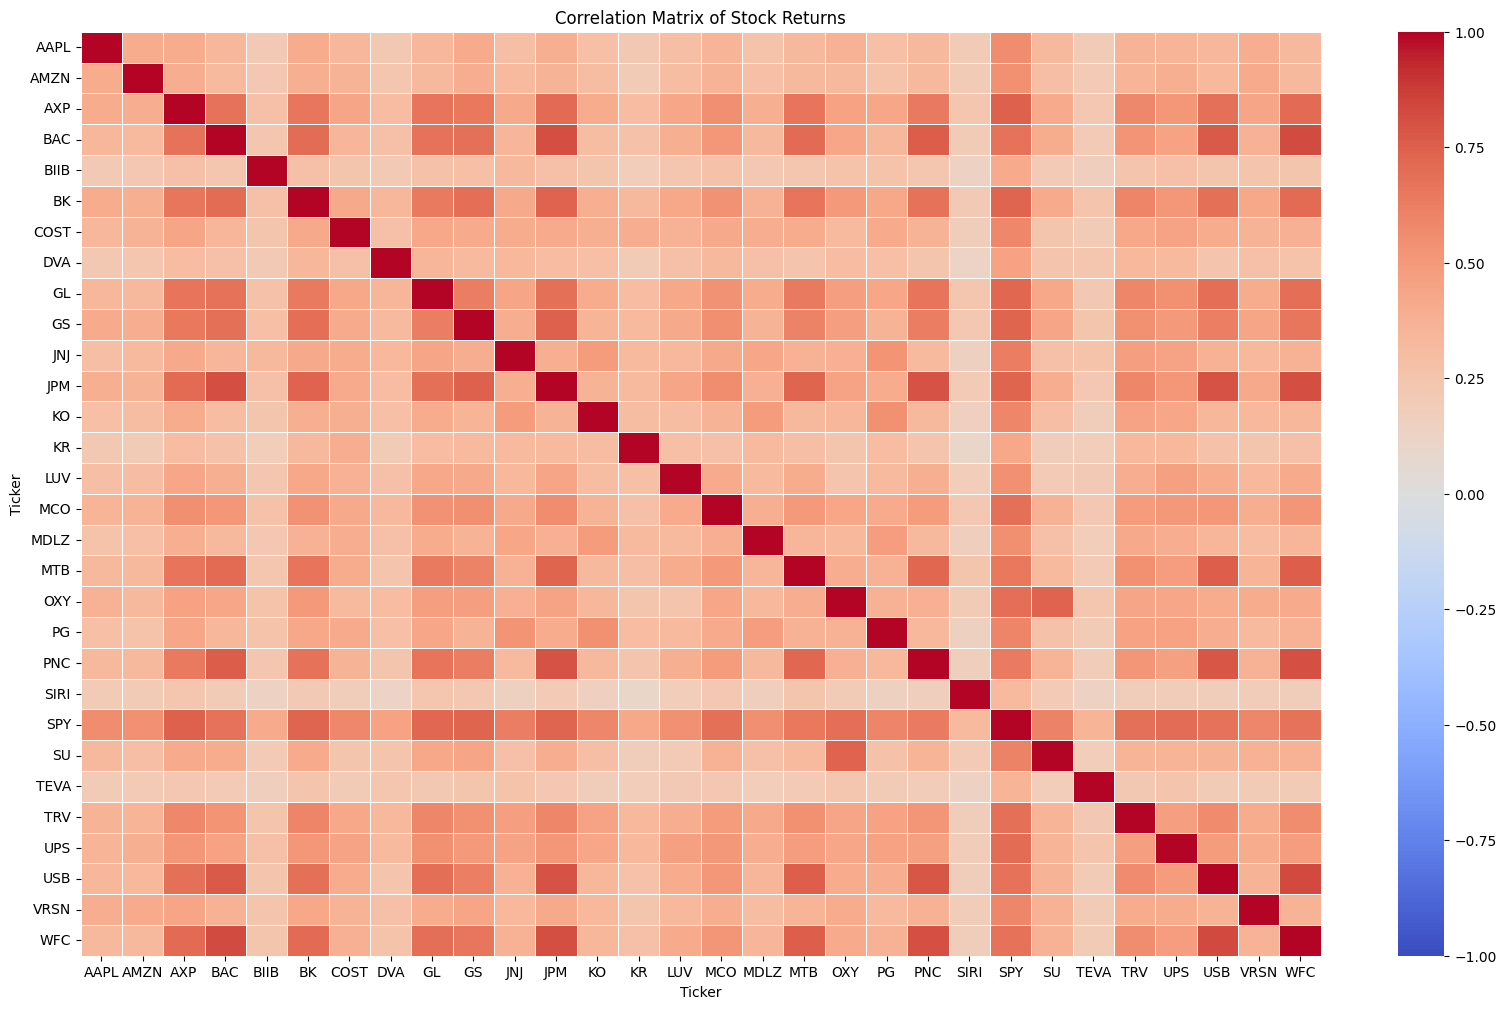

In [12]:
plot_correlation_matrix(
    returns_train, "Correlation Matrix of Stock Returns", figsize=(20, 12), annot=False
)

### Download and Prepare Macroeconomic Indicators

/home/amogus/github/pst/final_test/custom_libraries/preprocess_data.py:108: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_df_shifted = macro_df_shifted.fillna(method="ffill")


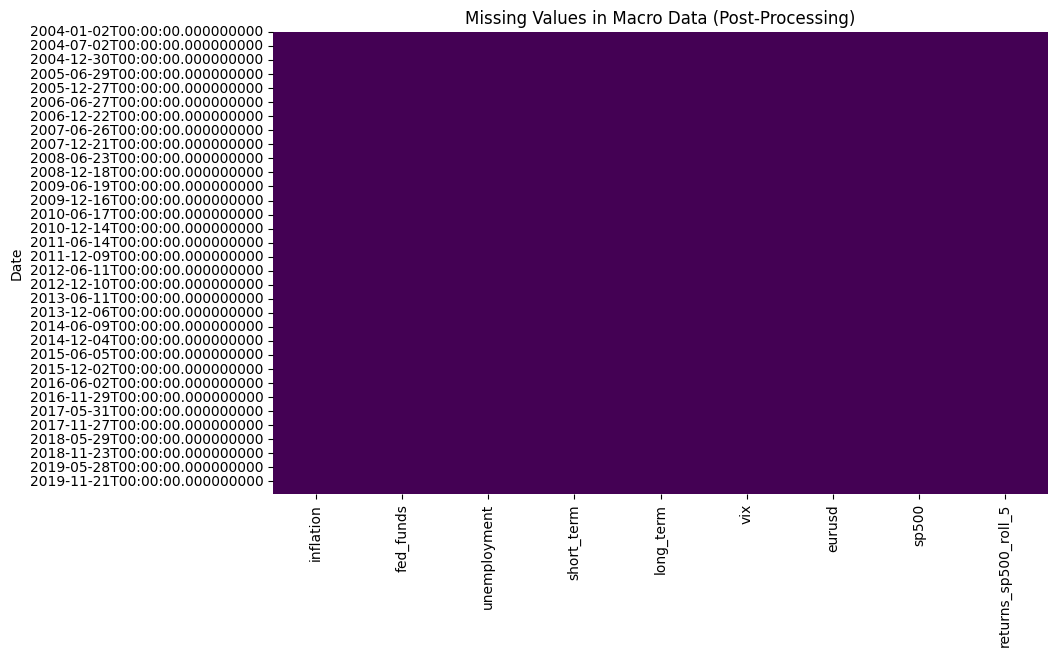

In [13]:
# Load FRED API Key
with open("key_fred.txt", "r") as file:
    fred_api_key = file.read().strip()

# Download FRED series
fred_data = download_fred_data(fred_api_key, pre_start_date, end_date)
vix_data, fx_data, sp500_data = download_other_data(pre_start_date, end_date)

macro_df = preprocess_macro_data(
    fred_data, vix_data, fx_data, sp500_data, start_date, backtest_end, returns_all.index
)

In [14]:
macro_df.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  
Date                                                             
2004-01-02  18.309999  1.259002  0.002053             -0.003099  
2004-01-05  18.219999  1.258194 -0.003099              0.000000  
2004-01-06  17.490000  1.268698  0.012319             -0.000321  
2004-01-07  16.730000  1.272103  0.001291             -0.001612  
2004-01-08  15.500000  1.264095  0.002364             -0.004547

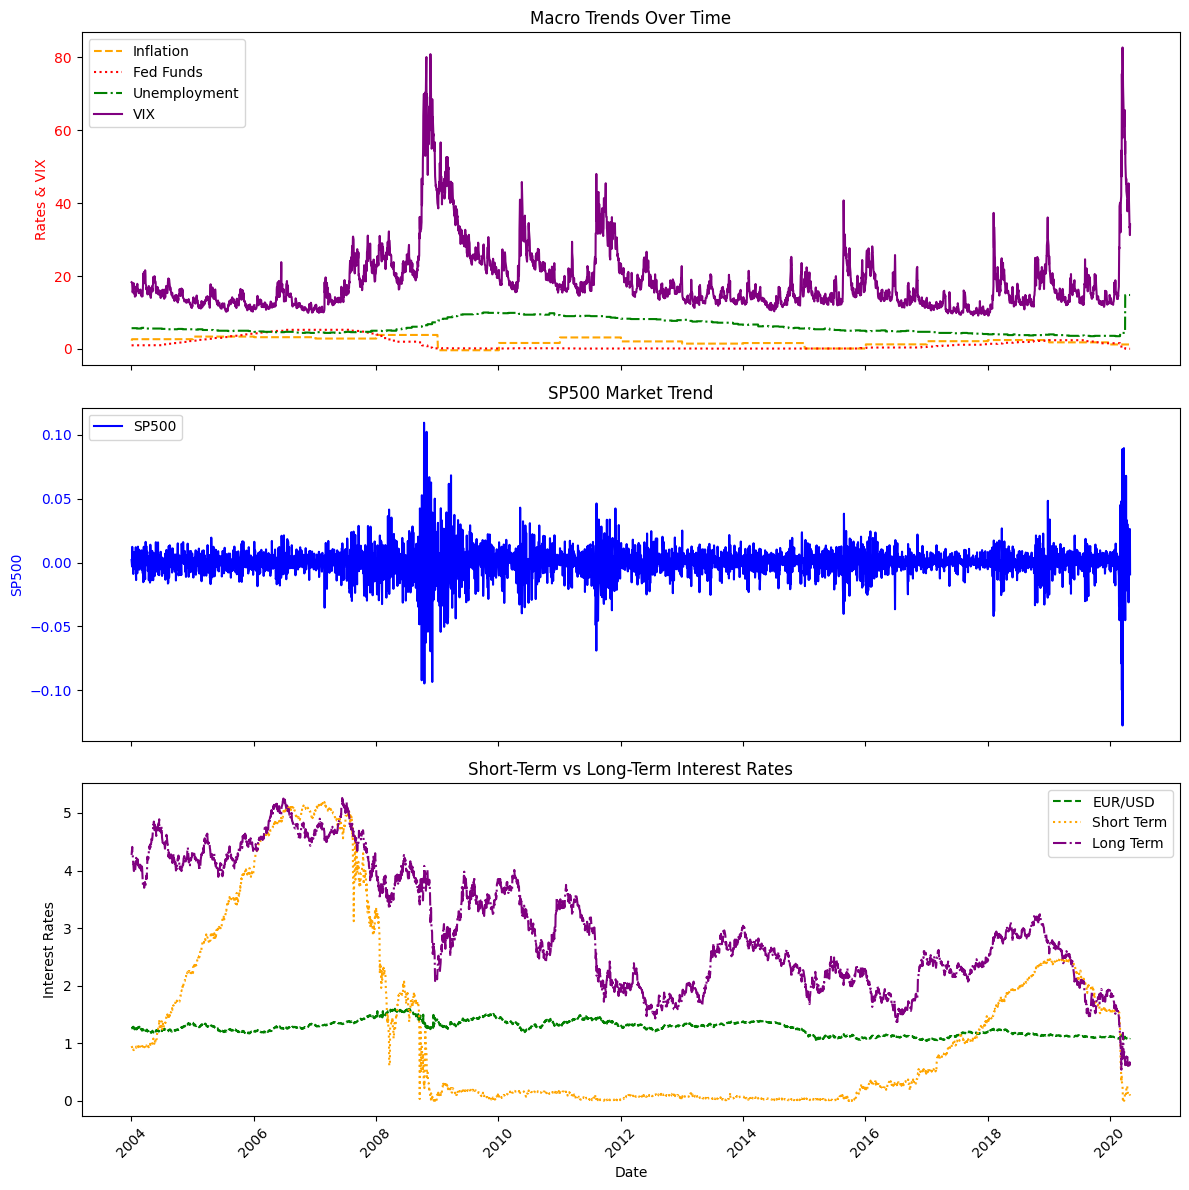

In [15]:
plot_macro_trend(macro_df)

In [16]:
input_features = process_input_features(
    macro_df,
    returns_all,
    market_data,
    start_date,
    end_date,
    portfolio_weights,
)

input_features.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  \
Date                                                              
2004-01-02  18.309999  1.259002  0.002053             -0.003099   
2004-01-05  18.219999  1.258194 -0.003099              0.000000   
2004-01-06  17.490000  1.268698  0.012319             -0.000321   
2004-01-07  16.730000  1.272103  0.001291             -0.001612   
2004-01-08  15.500000  1.264095  0.002364             -0.004547   

            portfolio_volatility  portfolio_volume  
Date                                                
2004-01-02              0.011617      7.338336e+07  
2004-01-05              0.012135      1.742616e+08  
2004-01-06              0.012069      1.974032e+08  
2004-01-07              0.012103      2.344443e+08  
2004-01-08              0.010964      1.942956e+08

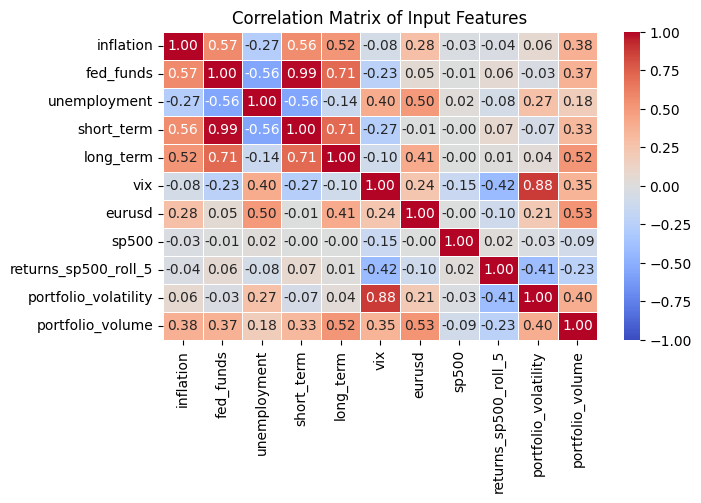

In [17]:
plot_correlation_matrix(input_features, "Correlation Matrix of Input Features")

In [18]:
print(f"#Nan in Input Features : {input_features.isna().sum().sum()}")

#Nan in Input Features : 0


In [19]:
input_train = input_features.loc[start_date:backtest_start]
input_test = input_features.loc[backtest_start:backtest_end]

# Scale input_features indicators
input_scaler = StandardScaler()
input_train_scaled = input_scaler.fit_transform(input_train)
input_test_scaled = input_scaler.transform(input_test)

## Define custom layers: Sampling, Reconstruction Loss, KL Divergence

In [20]:
from custom_libraries.custome_layer import (
    KLDivergenceLayer,
    SamplingLayer,
    ReconstructionLossLayer,
)

# Define the missing custom layer
custom_objects = {
    "KLDivergenceLayer": KLDivergenceLayer,
    "ReconstructionLossLayer": ReconstructionLossLayer,
    "SamplingLayer": SamplingLayer,
}

## Conditional VAE: Unconditioned Encoder, Conditioned Decoder with Dropout

In [21]:
from custom_libraries.custom_vae import (
    build_conditional_vae,
)

## Conditional Generator and Critic (WGAN-GP) with Increased Depth and Dropout

In [22]:
from custom_libraries.custom_wgangp import (
    build_conditional_generator,
    build_conditional_critic,
    train_conditional_wgan_gp,
)

## Training and Stress Testing

In [23]:
n_samples = min(returns_train_scaled.shape[0], input_train_scaled.shape[0])
returns_scaled = returns_train_scaled[:n_samples]
macro_train_scaled = input_train_scaled[:n_samples]

### VAE

In [24]:
return_dim = returns_scaled.shape[1]
input_dim = input_train_scaled.shape[1]
latent_dim = LATENT_DIM
noise_dim = NOISE_DIM

print(f"Returns dim: {return_dim}")
print(f"Input dim: {input_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Noise dim: {noise_dim}")

Returns dim: 30
Input dim: 11
Latent dim: 2
Noise dim: 10


In [26]:
if not LOAD_MODEL:
    print("Training Conditional VAE...")
    encoder, decoder, cvae, early_stop = build_conditional_vae(
        return_dim, input_dim, intermediate_dim=256, latent_dim=latent_dim
    )

    cvae.fit(
        [returns_scaled, input_train_scaled],
        epochs=EPOCHS_CVAE,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )
    z_mean_train, _, _ = encoder.predict(returns_scaled)

Training Conditional VAE...


I0000 00:00:1741719846.047587   38474 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Epoch 1/500


2025-03-11 15:04:07.233352: I external/local_xla/xla/service/service.cc:152] XLA service 0x7198380206e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-11 15:04:07.233362: I external/local_xla/xla/service/service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-03-11 15:04:07.263740: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741719847.415078   38659 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-03-11 15:04:07.898050: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-11 15:04:08.346378: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to lo

 82/115 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 1.8494

I0000 00:00:1741719851.227416   38659 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-11 15:04:11.967417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1123', 4 bytes spill stores, 4 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.8166 

2025-03-11 15:04:15.215774: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-03-11 15:04:15.345214: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads

2025-03-11 15:04:16.625821: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 4 bytes spill stores, 4 bytes spill loads

2025-03-11 15:04:16.885586: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_154', 8 bytes spill stores, 8 bytes spill loads



115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 1.8156 - val_loss: 1.3308
Epoch 2/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 1.4193 - val_loss: 1.2423
Epoch 3/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 1.3343 - val_loss: 1.2659
Epoch 4/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.2888 - val_loss: 1.2262
Epoch 5/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 1.2794 - val_loss: 1.2742
Epoch 6/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 1.2614 - val_loss: 1.2795
Epoch 7/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 1.2569 - val_loss: 1.2197
Epoch 8/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.2464 - val_loss: 1.2523
Epoch 9/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 1.2425 - val_loss: 1.2384
Epoch 10/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 1.2351 - val_loss: 1.2325
Epoch 11/500
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 1.2307 - val_loss: 1.2813
Epoch 12/500
115/115 ━━━━━━━━━━

### WGAN-GP

In [26]:
if not LOAD_MODEL:
    print("Training Conditional WGAN-GP...")
    generator = build_conditional_generator(noise_dim, input_dim, latent_dim)
    critic = build_conditional_critic(latent_dim, input_dim)
    generator, gen_losses, critic_losses, val_losses = train_conditional_wgan_gp(
        generator,
        critic,
        z_mean_train,
        input_train_scaled,
        input_test,
        noise_dim,
        epochs=EPOCHS_WGAN,
        important_index="returns_sp500_roll_5",
        patience=WGANGP_PATIENCE,
    )

Training Conditional WGAN-GP...


2025-03-11 12:21:31.736471: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1: Critic Loss = 14.9594, Gen Loss = -0.0954, Val Loss = -0.1589


2025-03-11 12:21:49.280437: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-11 12:22:24.300413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-11 12:23:34.471812: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10: Critic Loss = 8.0351, Gen Loss = -2.4860, Val Loss = -2.2136


2025-03-11 12:25:55.017699: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20: Critic Loss = -3.6089, Gen Loss = 2.1927, Val Loss = 2.1079


Epoch 30: Critic Loss = 2.1349, Gen Loss = -5.8833, Val Loss = -4.1479


2025-03-11 12:30:36.880117: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40: Critic Loss = 0.4398, Gen Loss = 1.2435, Val Loss = 0.6470


Epoch 50: Critic Loss = -2.2744, Gen Loss = 2.7788, Val Loss = 1.2699


Epoch 60: Critic Loss = 2.9258, Gen Loss = 0.3542, Val Loss = 0.3535


2025-03-11 12:40:00.621809: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70: Critic Loss = 1.9647, Gen Loss = -0.4025, Val Loss = -0.1810


Epoch 80: Critic Loss = -0.6006, Gen Loss = -1.5266, Val Loss = -0.2148


Epoch 90: Critic Loss = 6.8210, Gen Loss = 0.6867, Val Loss = 0.4264


Epoch 100: Critic Loss = 0.4575, Gen Loss = 2.1197, Val Loss = 1.1005


Epoch 110: Critic Loss = 0.0772, Gen Loss = 1.4260, Val Loss = 0.7473


Epoch 120: Critic Loss = 0.0538, Gen Loss = 1.3820, Val Loss = 0.6801


2025-03-11 12:58:53.053153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130: Critic Loss = 0.0250, Gen Loss = 1.1510, Val Loss = 0.5559


Epoch 140: Critic Loss = 0.0185, Gen Loss = 1.0715, Val Loss = 0.5199


Epoch 150: Critic Loss = 0.0174, Gen Loss = 0.9284, Val Loss = 0.4625


Epoch 160: Critic Loss = 0.0145, Gen Loss = 0.8191, Val Loss = 0.3988


Epoch 170: Critic Loss = 0.0135, Gen Loss = 0.7189, Val Loss = 0.3667


Epoch 180: Critic Loss = 0.0122, Gen Loss = 0.6242, Val Loss = 0.3124


Epoch 190: Critic Loss = 0.0118, Gen Loss = 0.5592, Val Loss = 0.2738


Epoch 200: Critic Loss = 0.0113, Gen Loss = 0.5487, Val Loss = 0.2714


Epoch 210: Critic Loss = 0.0112, Gen Loss = 0.4542, Val Loss = 0.2154


Epoch 220: Critic Loss = 0.0103, Gen Loss = 0.4786, Val Loss = 0.2352


Epoch 230: Critic Loss = 0.0124, Gen Loss = 0.4602, Val Loss = 0.2221


Epoch 240: Critic Loss = 0.0116, Gen Loss = 0.4810, Val Loss = 0.2218


Epoch 250: Critic Loss = 0.0123, Gen Loss = 0.4767, Val Loss = 0.2129


2025-03-11 13:36:33.929836: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 260: Critic Loss = 0.0126, Gen Loss = 0.5183, Val Loss = 0.2345


Epoch 270: Critic Loss = 0.0107, Gen Loss = 0.4636, Val Loss = 0.2285


Epoch 280: Critic Loss = 0.0099, Gen Loss = 0.4923, Val Loss = 0.2370


Epoch 290: Critic Loss = 0.0095, Gen Loss = 0.4709, Val Loss = 0.2205


Epoch 300: Critic Loss = 0.0086, Gen Loss = 0.4532, Val Loss = 0.2146


Epoch 310: Critic Loss = 0.0092, Gen Loss = 0.4633, Val Loss = 0.2227


Epoch 320: Critic Loss = 0.0080, Gen Loss = 0.4509, Val Loss = 0.2286


Epoch 330: Critic Loss = 0.0082, Gen Loss = 0.4448, Val Loss = 0.2270


Epoch 340: Critic Loss = 0.0083, Gen Loss = 0.4353, Val Loss = 0.2096


Epoch 350: Critic Loss = 0.0078, Gen Loss = 0.4470, Val Loss = 0.2213


Epoch 360: Critic Loss = 0.0070, Gen Loss = 0.4090, Val Loss = 0.2198


Epoch 370: Critic Loss = 0.0067, Gen Loss = 0.4454, Val Loss = 0.2219


Epoch 380: Critic Loss = 0.0059, Gen Loss = 0.4512, Val Loss = 0.2377


Epoch 390: Critic Loss = 0.0057, Gen Loss = 0.3914, Val Loss = 0.2382


Epoch 400: Critic Loss = 0.0055, Gen Loss = 0.4412, Val Loss = 0.2525


Epoch 410: Critic Loss = 0.0054, Gen Loss = 0.4161, Val Loss = 0.2437


Epoch 420: Critic Loss = 0.0042, Gen Loss = 0.4163, Val Loss = 0.2154


Epoch 430: Critic Loss = 0.0047, Gen Loss = 0.4277, Val Loss = 0.2393


Epoch 440: Critic Loss = 0.0050, Gen Loss = 0.4102, Val Loss = 0.2525


Early stopping triggered at epoch 444


#### Plot Losses

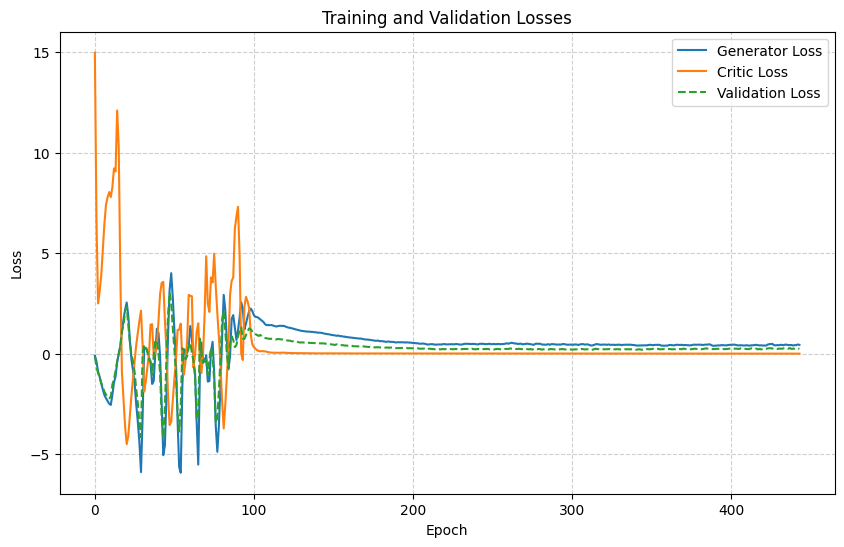

In [27]:
if not LOAD_MODEL:
    plot_gan_losses(gen_losses, critic_losses, val_losses)

### Save & Load Models

In [ ]:
if LOAD_MODEL:
    encoder, decoder, cvae, generator, critic = load_models(
        custom_objects, FOLDER_LOAD_MODELS
    )
    print("Load models")
else:
    save_models(encoder, decoder, cvae, generator, critic)

### Generate New Synthetic Scenarios

#### Scenario

In [29]:
stress_values = {
#    "fed_funds": 0.01,
#    "long_term": 2.0,
#    "vix": 99.0,
#    "eurusd": 2.0,
#    "inflation": 4.0,
#    "unemployment": 20.0,
}


#### Backtesting

In [30]:
backtest_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
313/313 ━━━━━

In [31]:
print("Rolling backtest results:")
backtest_df.head()

Rolling backtest results:


forecast_date  hist_portfolio_return  synthetic_VaR  synthetic_ES
0    2020-02-20              -0.006224      -0.036793     -0.036967
1    2020-02-21              -0.016266      -0.036286     -0.036444
2    2020-02-24              -0.042082      -0.042325     -0.042509
3    2020-02-25              -0.032877      -0.031858     -0.032038
4    2020-02-26               0.001837      -0.028154     -0.028340

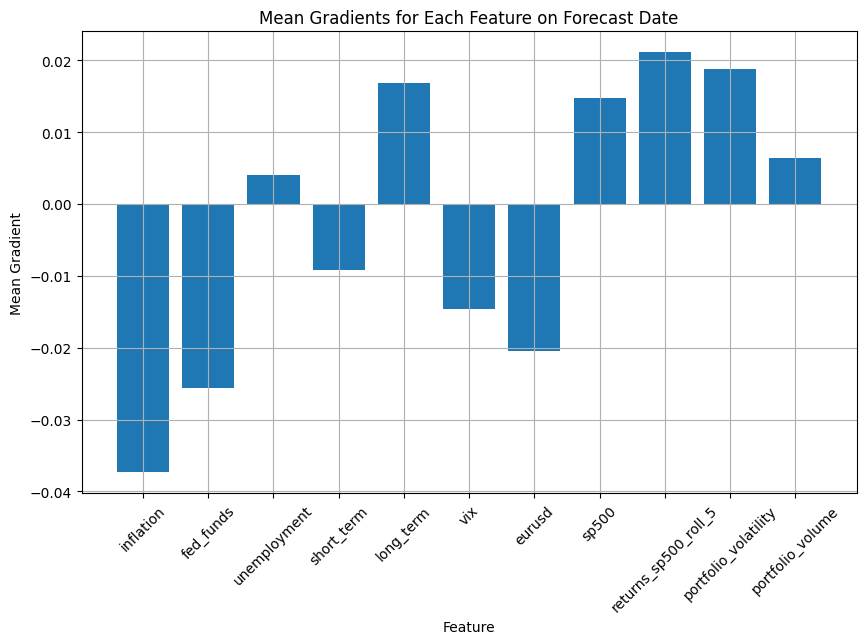

In [32]:
plot_mean_grad_features(input_test, generator)

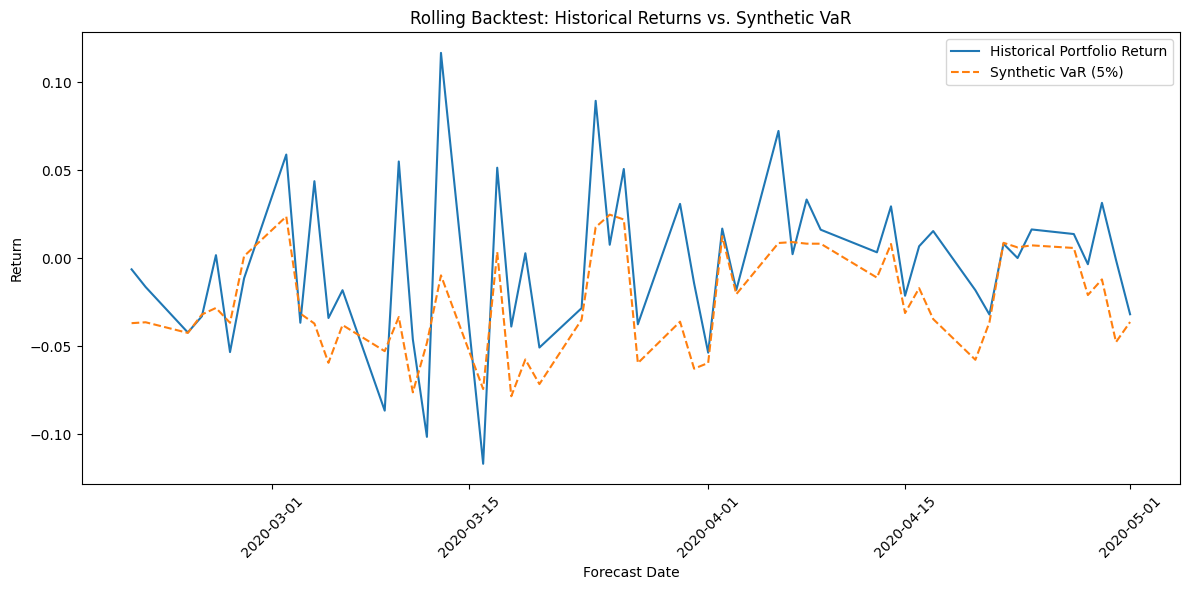

In [33]:
plot_historical_vs_synthetic_var_period(backtest_df)

In [34]:
backtest_tickers_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
    by_ticker=True,
)

136/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
313/313 ━━━

In [35]:
print("Rolling backtest results:")
backtest_tickers_df.head()

Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022895         -0.026892        -0.012377   
2    2020-02-24         -0.048666         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001962          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051728         -0.005753       -0.036359         -0.028297   
4        -0.014584          0.010252       -0.005304          0.002687   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.034110          -0.036959   
1        -0.006638       -0.009218  ...         -0.033884          -0.035603   
2        -0.014735       -0.032012  ...         -0.040918          -0.044714   
3        -0.022086       -0.034235  ...         -0.037915          -0.034795   
4        -0.000123       -0.022962  ...         -0.033498          -0.032529   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.016414        -0.040876          -0.039045         -0.028589   
1         -0.016171        -0.041187          -0.039119         -0.025157   
2         -0.021574        -0.053667          -0.044104         -0.031403   
3         -0.016918        -0.040215          -0.034638         -0.019387   
4         -0.014144        -0.030453          -0.029534         -0.015162   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.026086         -0.021255          -0.041471         -0.022179  
1         -0.025472         -0.019936          -0.040218         -0.026158  
2         -0.031000         -0.026137          -0.043548         -0.028334  
3         -0.023563         -0.018890          -0.031564         -0.027087  
4         -0.018613         -0.016163          -0.029489         -0.030037  

[5 rows x 91 columns]

In [36]:
backtest_tickers_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
    by_ticker=True,
)

121/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
313/313 ━━━

In [37]:
print("Rolling backtest results:")
backtest_tickers_df.head()

Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022895         -0.026892        -0.012377   
2    2020-02-24         -0.048666         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001962          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051728         -0.005753       -0.036359         -0.028297   
4        -0.014584          0.010252       -0.005304          0.002687   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.034101          -0.036940   
1        -0.006638       -0.009218  ...         -0.033894          -0.035621   
2        -0.014735       -0.032012  ...         -0.040931          -0.044739   
3        -0.022086       -0.034235  ...         -0.037919          -0.034798   
4        -0.000123       -0.022962  ...         -0.033496          -0.032526   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.016408        -0.040849          -0.039035         -0.028579   
1         -0.016176        -0.041206          -0.039128         -0.025166   
2         -0.021583        -0.053699          -0.044111         -0.031413   
3         -0.016919        -0.040219          -0.034640         -0.019388   
4         -0.014143        -0.030451          -0.029534         -0.015160   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.026083         -0.021241          -0.041460         -0.022159  
1         -0.025474         -0.019948          -0.040230         -0.026176  
2         -0.031004         -0.026154          -0.043568         -0.028366  
3         -0.023564         -0.018893          -0.031566         -0.027092  
4         -0.018612         -0.016162          -0.029489         -0.030035  

[5 rows x 91 columns]

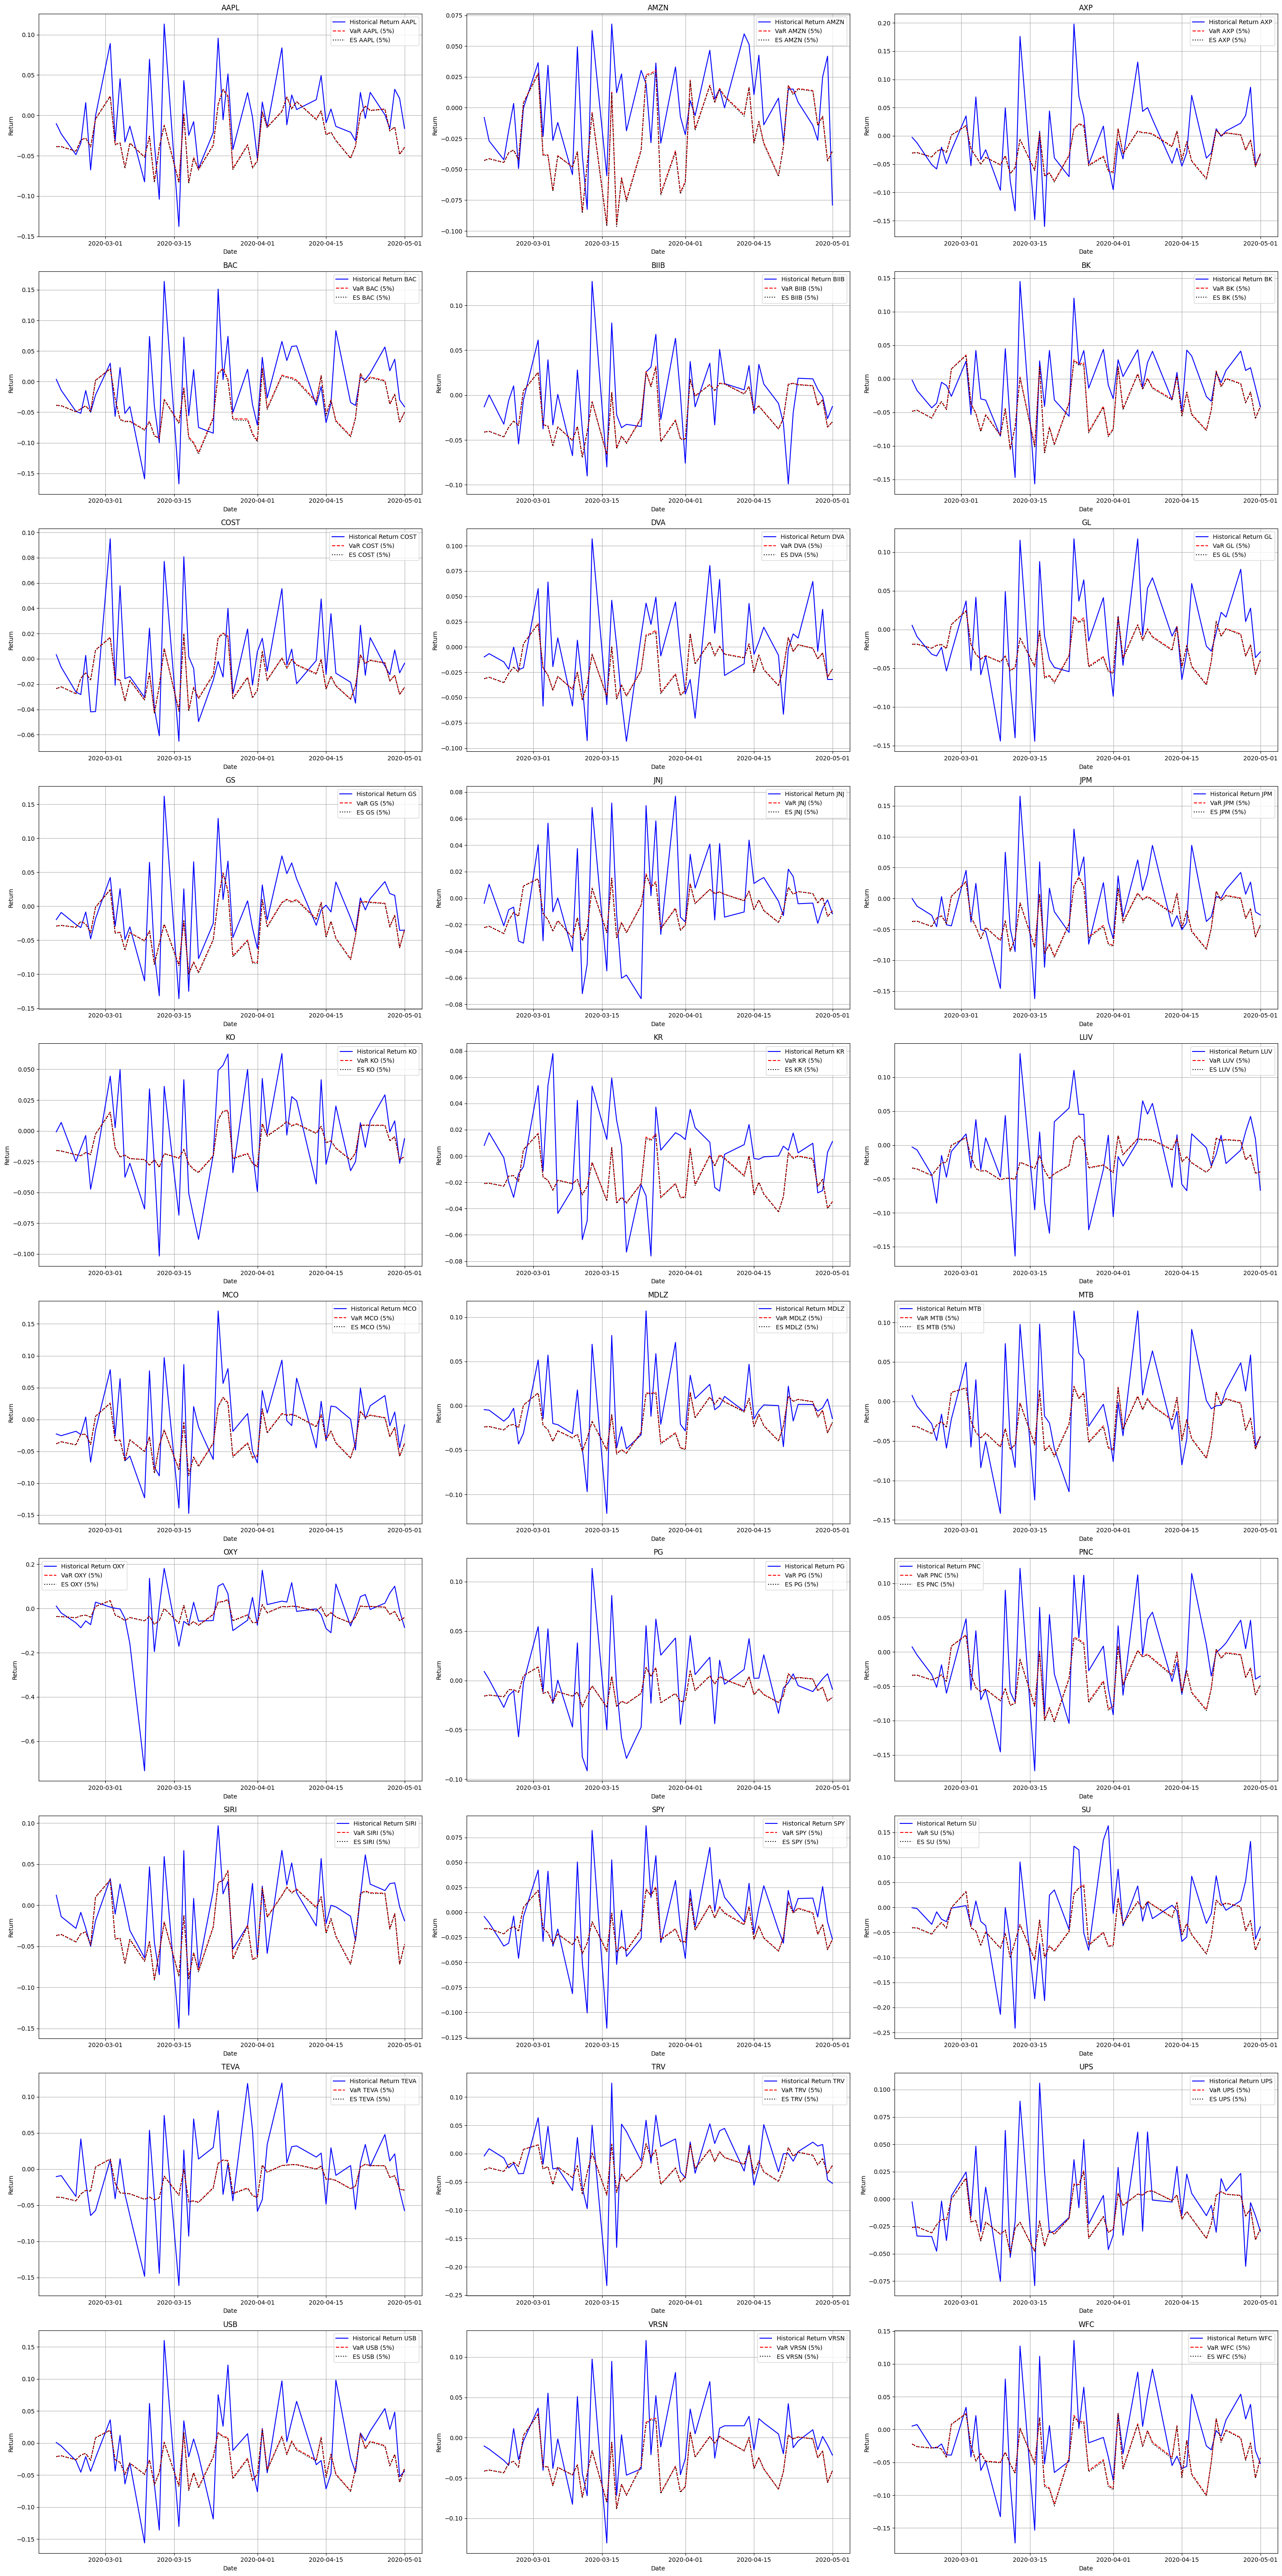

In [38]:
plot_historical_vs_synthetic_var_period_per_tickers(backtest_tickers_df, returns_test)

In [39]:
tickers_list = returns_test.columns.tolist()

hist_returns, synthetic_vars = backtest_tickers_ret_syn(
    tickers_list, backtest_tickers_df
)

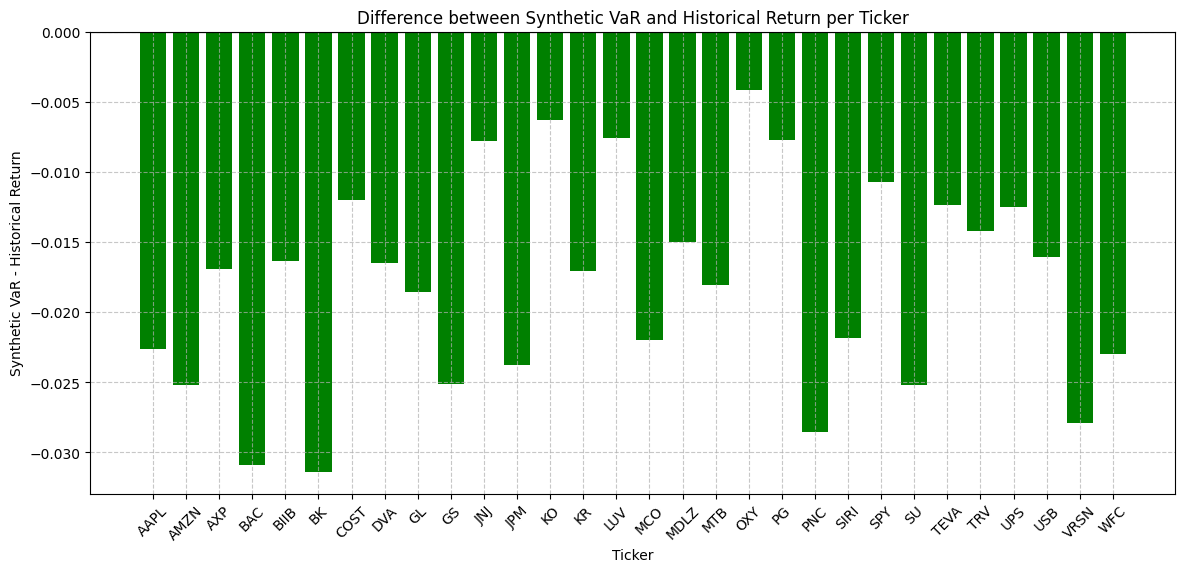

In [40]:
plot_bar_diff(hist_returns, synthetic_vars, tickers_list)

/home/amogus/github/pst/final_test/custom_libraries/utils_plot.py:466: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


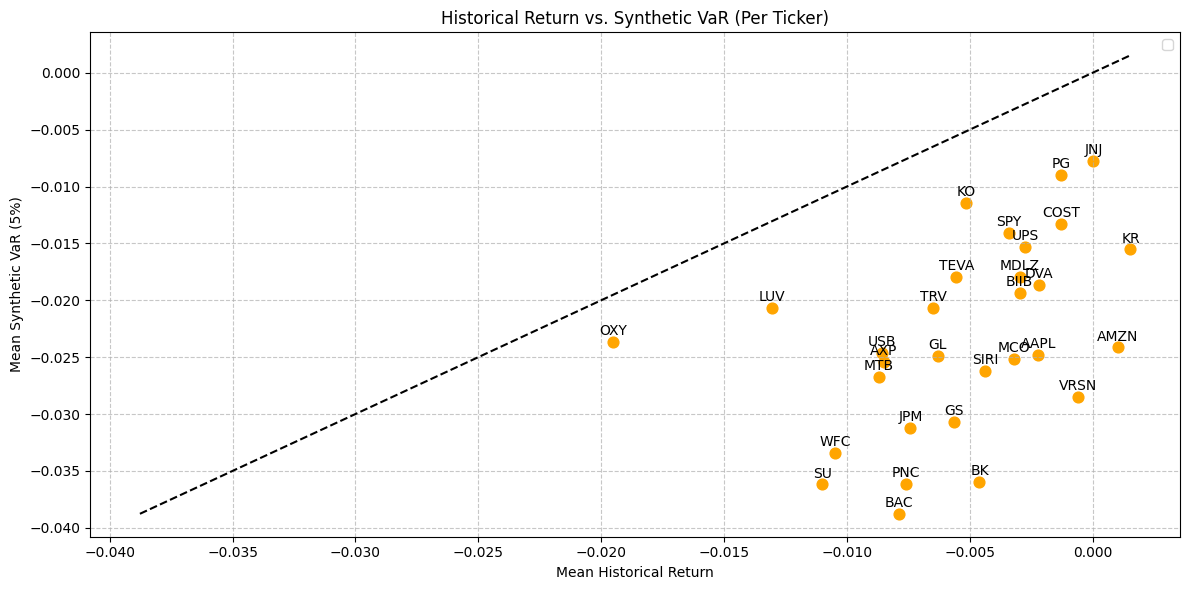

In [41]:
plot_scatter_actual_vs_synthetic_oblique(hist_returns, synthetic_vars, tickers_list)

127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 


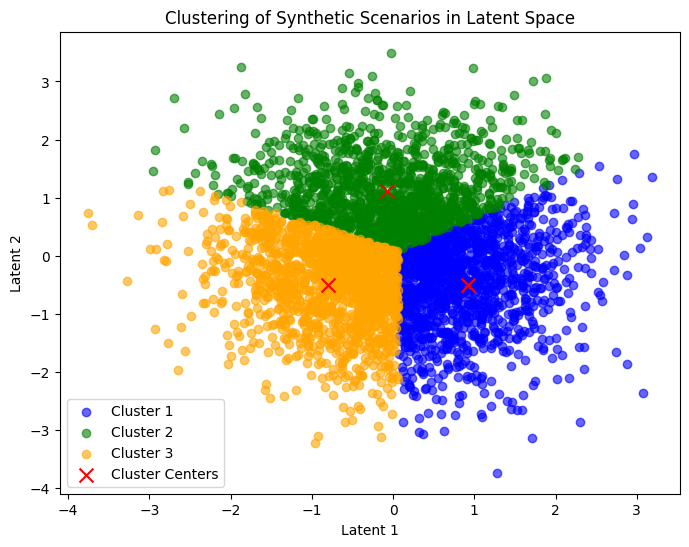

In [42]:
plot_latent_space_clustering(encoder, returns_train_scaled, SEED_RANDOM)

In [43]:
synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d = (
    detailed_evaluation_forecast(
        returns_test,
        input_test_scaled,
        generator,
        decoder,
        returns_scaler,
        NUM_SCENARIOS,
        NOISE_DIM,
        portfolio_weights,
        index_date=0,
    )
)

Forecast date: 2020-02-20 00:00:00
140/313 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
Detailed evaluation for forecast date: 2020-02-20 00:00:00
Synthetic Portfolio Returns - Summary:
count    10000.000000
mean        -0.036277
std          0.000299
min         -0.037710
25%         -0.036458
50%         -0.036258
75%         -0.036074
max         -0.035161
dtype: float64
Synthetic VaR (5th percentile): -0.0368
Synthetic ES: -0.0370


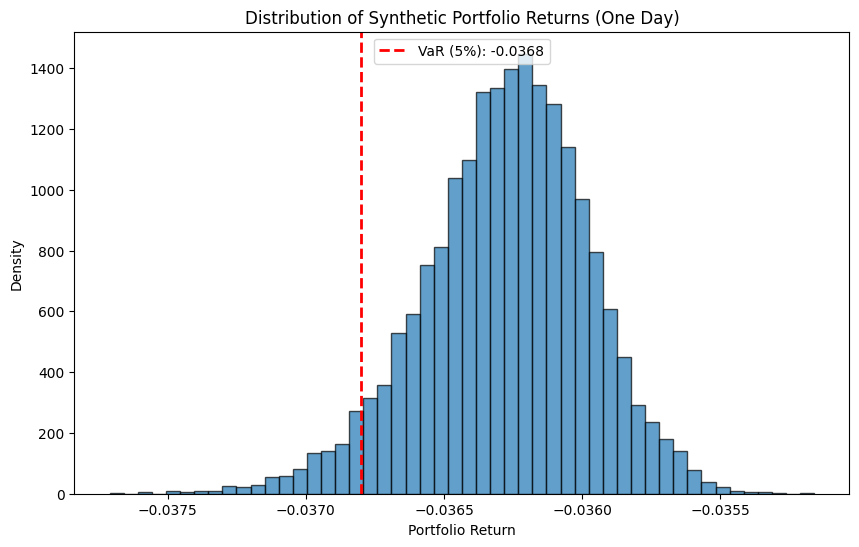

In [44]:
plot_distribution_synthetic_portfolio(synthetic_portfolio_returns_d, var_synth_d)

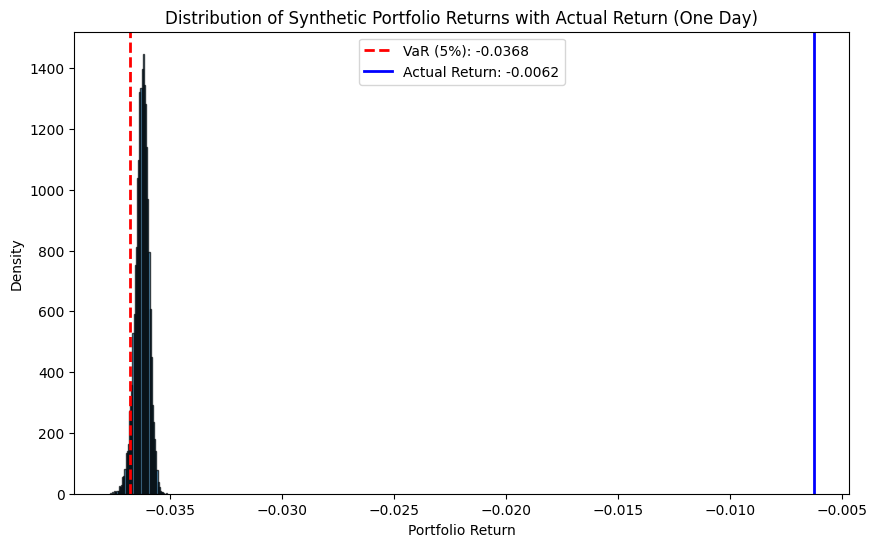

In [45]:
plot_distribution_synthetic_portfolio(
    synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d
)